# NPTracer Tutorial

Welcome to **N**-body **P**article **Tracer** (NPTracer), the package that will solve all your headaches from manipulating the outputs of N-body simulations for planet formation. 

In this guide you will learn how to use NPTracer and get the data ready for making beautiful plots. By this point you should have installed NPTracer, if not follow the instructions in the [README](https://github.com/spencerw/Nptracer/blob/main/README.md) file. The only package from NPTracer you will need to import is the *Driver*, it will handle the reading and analysis of the data for you.

In [11]:
from nptracer.driver import Driver

Let's say that we want to read and analyze the snapshots from a N-body simulation with [GENGA](https://genga.readthedocs.io/en/latest/). If you dont have GENGA data, no worries, we have some data we generated for this tutorial, included in the base repository. To instantiate the driver, you only will need to designate the path to the data folder, and the keyword to indicate the format of the data.

In [12]:
path = 'simdata/genga/'
driver = Driver(path, 'genga')

Loaded table with 1994 rows and 10 columns


Under the hood, the Driver object reads the data with a DataLoader object, which give the cartesian positions, velocities, mass, radius of all the particles (idenfied by ids) in all epochs. The the Analyzer object transform all this data into Keplerian elements. This is all placed into a Pandas DataFrame, which can be accessed through the following "data" attribute, let's see the columns:

In [13]:
driver.analyzer.snap_data

,t,id,m,r,px,py,pz,vx,vy,vz,a,e,inc,asc_node,omega,M
0,0.000000,0,1.152102e-06,0.000038,-0.018803,-0.009886,-0.000011,0.891686,-1.728983,0.000574,0.021349,0.009293,0.000618,4.690632,4.199109,1.011150
1,0.000000,23,1.410008e-06,0.000041,-0.021591,-0.064846,0.000163,0.992859,-0.360378,0.003131,0.065285,0.053982,0.003754,3.703495,4.321262,2.623900
2,0.000000,22,1.977740e-07,0.000021,-0.116791,0.088365,0.010029,-0.431348,-0.580408,0.004898,0.141095,0.041207,0.068765,1.030170,4.415477,3.347719
3,0.000000,21,2.564861e-07,0.000023,-0.082606,0.145322,0.000657,-0.598957,-0.339143,-0.000107,0.165495,0.010202,0.003936,0.475822,4.916512,2.976878
4,0.000000,20,1.049919e-06,0.000037,0.004875,-0.042437,0.000020,1.366030,0.139696,0.002131,0.043008,0.014181,0.001615,4.532888,5.492601,1.071911
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,73921.971253,12,4.395171e-06,0.000059,0.019923,-0.007497,-0.000918,0.687368,1.819066,0.077163,0.021492,0.008657,0.058570,0.466214,5.496744,6.243334
1990,73921.971253,23,2.320884e-06,0.000048,0.007270,0.064262,0.012615,-1.025100,0.242198,0.059177,0.060823,0.151891,0.195341,0.055886,5.414666,2.158066
1991,73921.971253,20,2.977838e-06,0.000052,0.041732,0.009862,-0.002643,-0.269286,1.237940,-0.132391,0.038066,0.130869,0.119810,2.836242,0.701852,2.959300
1992,73921.971253,17,3.109612e-06,0.000053,0.014787,0.000963,0.000283,-0.035838,2.194797,0.027372,0.013386,0.117721,0.022291,5.322280,4.547084,2.718533


Let's say we want to know the IDs of the particles that survive to the final step of the simulation:

In [14]:
driver.analyzer.ids_final

array([12, 23, 20, 17,  7], dtype=int64)

If we want to plot the evolution in mass of particle #20 throughout the simulation, the DataAnalyzer provides this information in the form of two 1d NumPy arrays through the following function:

In [15]:
time, m = driver.analyzer.get_time_prop(20, 'm')

Let's import our best friend matplotlib and make a plot with this data (we also use astropy to convert the data from simulation units to a more tractable form):

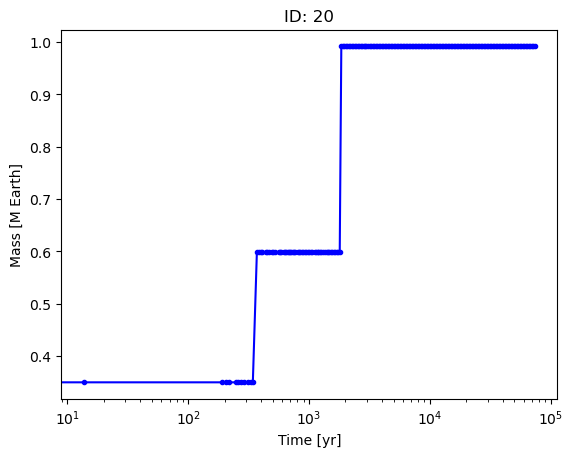

In [16]:
import matplotlib.pyplot as plt
from astropy import units as u

fig, ax = plt.subplots()
ax.plot(time, (m*u.M_sun).to(u.M_earth), '.-', c='b')
ax.set_xlabel('Time [yr]'); ax.set_ylabel('Mass [M Earth]'); ax.set_title(f'ID: 20')
ax.set_xscale('log')


We see that particle #20 underwent 3 collision and attained a final mass of 1 M Earth! Now let's plot radius, semimajor axis and eccentricity for all particles that survived the simulation.

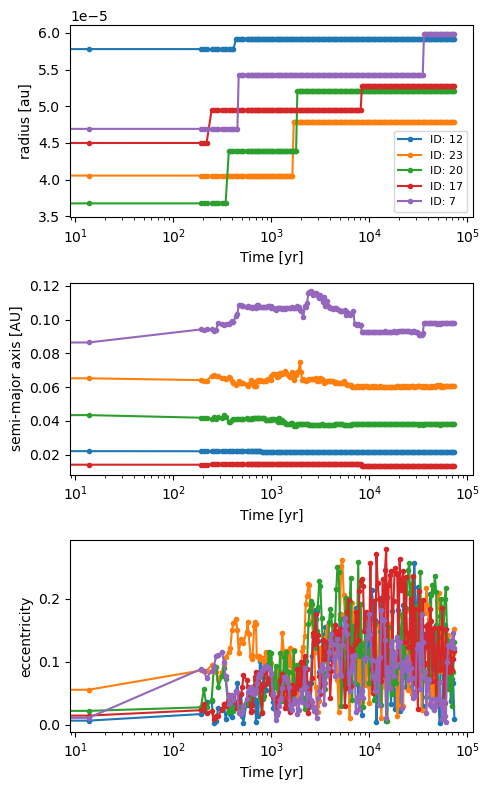

In [17]:
fig, ax = plt.subplots(3, 1, figsize=(5, 8))
for i, (prop, ylabel) in enumerate(zip(['r', 'a', 'e'], ['radius [au]', 'semi-major axis [AU]', 'eccentricity'])):
    for id in driver.analyzer.ids_final:
        time4plot, prop4plot = driver.analyzer.get_time_prop(id, prop)
        ax[i].plot(time4plot, prop4plot, '.-', label=f'ID: {id}')
        ax[i].set_xlabel('Time [yr]'); ax[i].set_ylabel(ylabel); 
        ax[i].set_xscale('log')
ax[0].legend(fontsize=8)
plt.tight_layout()


The analyzer object also has a method to give us bulk statistics of the simulation as a function of time. So let's see how the maximum mass of the system evolves over time and compare it with the average mass of all the particles.

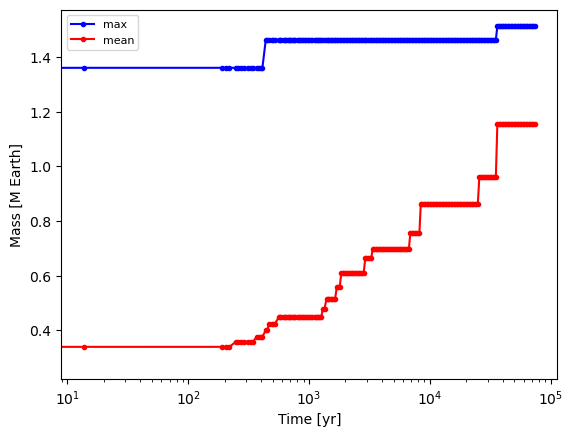

In [18]:
time, max_m = driver.analyzer.get_time_func('m', 'max')
time, mean_m = driver.analyzer.get_time_func('m', 'mean')

fig, ax = plt.subplots()
ax.plot(time, (max_m*u.M_sun).to(u.M_earth), '.-', c='b', label='max')
ax.plot(time, (mean_m*u.M_sun).to(u.M_earth), '.-', c='r', label='mean')
ax.set_xlabel('Time [yr]'); ax.set_ylabel('Mass [M Earth]'); 
ax.set_xscale('log');
ax.legend(fontsize=8)
plt.show()

The analyzer will also preprocess the data from the collision log file. The entries are sorted into a tree structure. The root is an empty node, and the children of the root correspond to parent particles. The subtree of each parent particle contains the collision history of that body and the leaf nodes correspond to the bodies in the intial condition file.

In [21]:
driver.analyzer.proc_collisions()

for node in driver.analyzer.coll_tree.root.children:
    print(node.id, len(node.children))

Building collision trees...
12.0 4
17.0 3
20.0 2
7.0 2
10.0 1
8.0 1
23.0 1


GENGA is not the only format supported by NPTracker. An entirely different data format (in this case, outputs from the code ChaNGa) can be read with only a change to a keyword in the Driver constructor:

In [9]:
path = 'simdata/changa/'
driver = Driver(path, 'changa')

Loaded table with 88903 rows and 10 columns
